**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
# matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()
####################################################
from tifffile import imwrite
import pathlib as pt

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [2]:
FOLD = 3
model_dir = pt.Path.home() / f"Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SUPERVISED_PERF_FIG/weights/fold_{FOLD}"

In [3]:
path_images = pt.Path().home() / f"Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SUPERVISED_PERF_FIG//INFERENCE/fold{FOLD}"
X = sorted(glob(str(path_images / '*.tif')))
X = [i for i in X if 'label' not in i]
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [4]:
demo_model = False

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model = StarDist3D(None, name='stardist', basedir=model_dir)
None;

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.598946, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [5]:
NMS_threshold_values = np.arange(0.1, 1, 0.1)
prob_thresh_values = np.arange(0.1, 1, 0.1)
NMS_threshold_values = np.round(NMS_threshold_values, 2)
prob_thresh_values = np.round(prob_thresh_values, 2)
save_dir = pt.Path(f"./stardist_hyperparams_check/fold{FOLD}")
save_dir.mkdir(exist_ok=True, parents=False)

img = normalize(X[0], 1,99.8, axis=axis_norm)
for nms_thresh in NMS_threshold_values:
    for prob_thresh in prob_thresh_values:
        print(f"nms_thresh: {nms_thresh}, prob_thresh: {prob_thresh}")
        labels, details = model.predict_instances(img, prob_thresh=prob_thresh, nms_thresh=nms_thresh)
        imwrite(str(save_dir / f"stardist_nms_{nms_thresh}_prob_{prob_thresh}.tif"), labels.astype(np.uint32))

nms_thresh: 0.1, prob_thresh: 0.1
nms_thresh: 0.1, prob_thresh: 0.2
nms_thresh: 0.1, prob_thresh: 0.3
nms_thresh: 0.1, prob_thresh: 0.4
nms_thresh: 0.1, prob_thresh: 0.5
nms_thresh: 0.1, prob_thresh: 0.6
nms_thresh: 0.1, prob_thresh: 0.7
nms_thresh: 0.1, prob_thresh: 0.8
nms_thresh: 0.1, prob_thresh: 0.9
nms_thresh: 0.2, prob_thresh: 0.1
nms_thresh: 0.2, prob_thresh: 0.2
nms_thresh: 0.2, prob_thresh: 0.3
nms_thresh: 0.2, prob_thresh: 0.4
nms_thresh: 0.2, prob_thresh: 0.5
nms_thresh: 0.2, prob_thresh: 0.6
nms_thresh: 0.2, prob_thresh: 0.7
nms_thresh: 0.2, prob_thresh: 0.8
nms_thresh: 0.2, prob_thresh: 0.9
nms_thresh: 0.3, prob_thresh: 0.1
nms_thresh: 0.3, prob_thresh: 0.2
nms_thresh: 0.3, prob_thresh: 0.3
nms_thresh: 0.3, prob_thresh: 0.4
nms_thresh: 0.3, prob_thresh: 0.5
nms_thresh: 0.3, prob_thresh: 0.6
nms_thresh: 0.3, prob_thresh: 0.7
nms_thresh: 0.3, prob_thresh: 0.8
nms_thresh: 0.3, prob_thresh: 0.9
nms_thresh: 0.4, prob_thresh: 0.1
nms_thresh: 0.4, prob_thresh: 0.2
nms_thresh: 0.

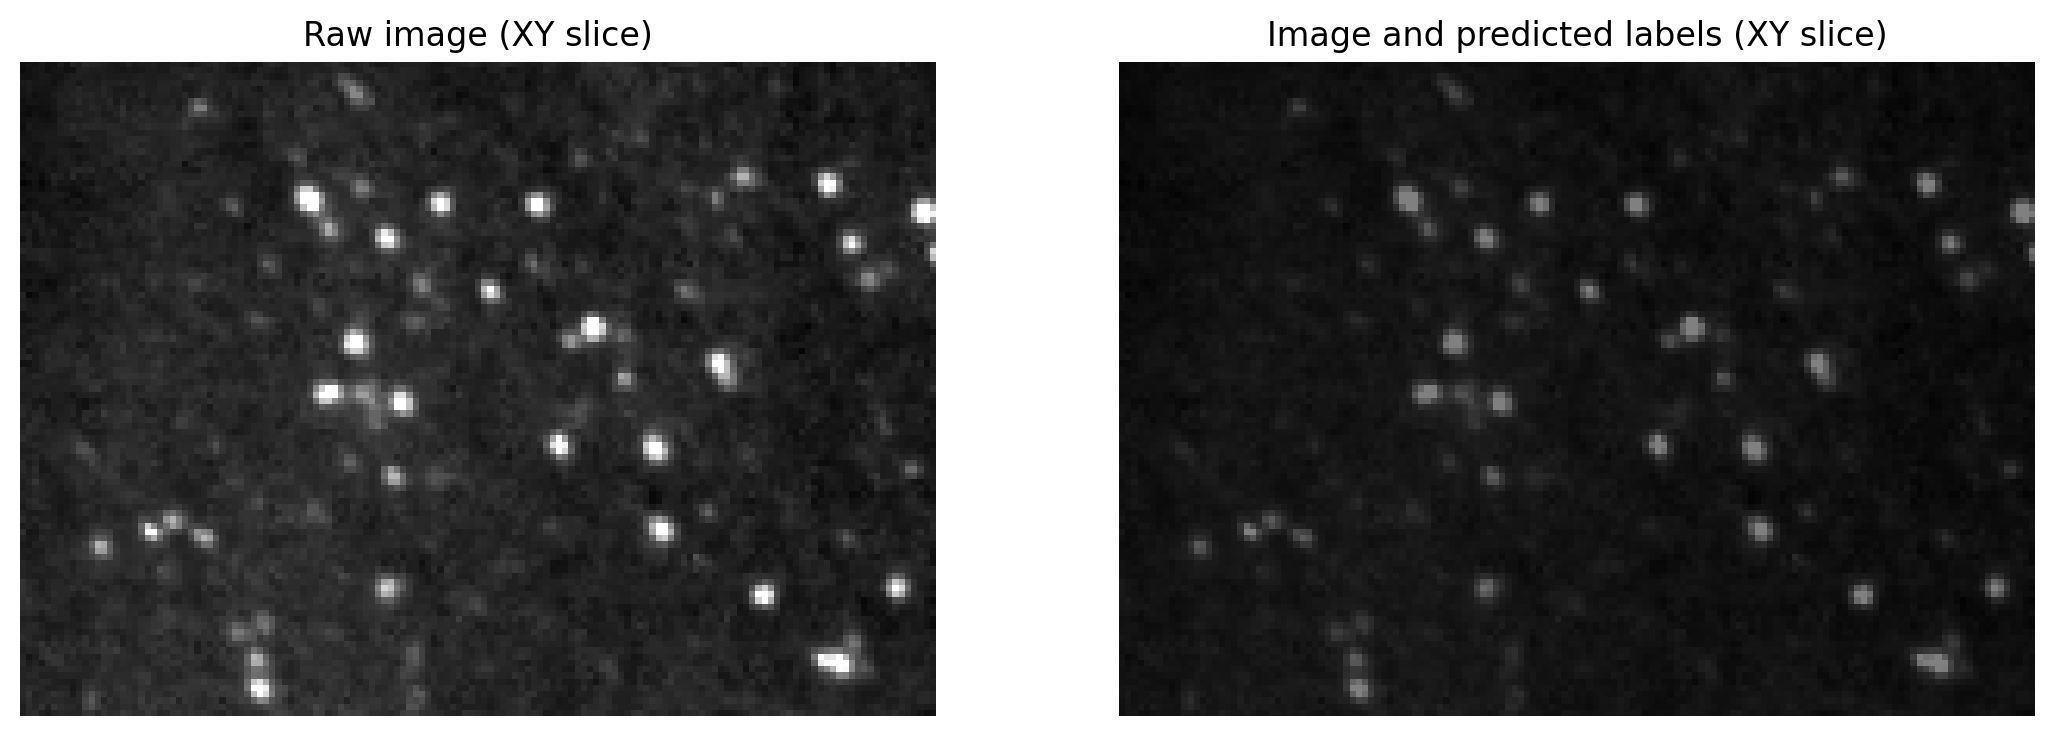

In [6]:
plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predicted label image to disk.

In [7]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='ZYX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='ZYX')

# Example results

In [8]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,8))
    z = img.shape[0] // 2
    y = img.shape[1] // 2
    img_show = img if img.ndim==3 else img[...,:3]    
    plt.subplot(221); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.subplot(222); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.subplot(223); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.imshow(labels[:,y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

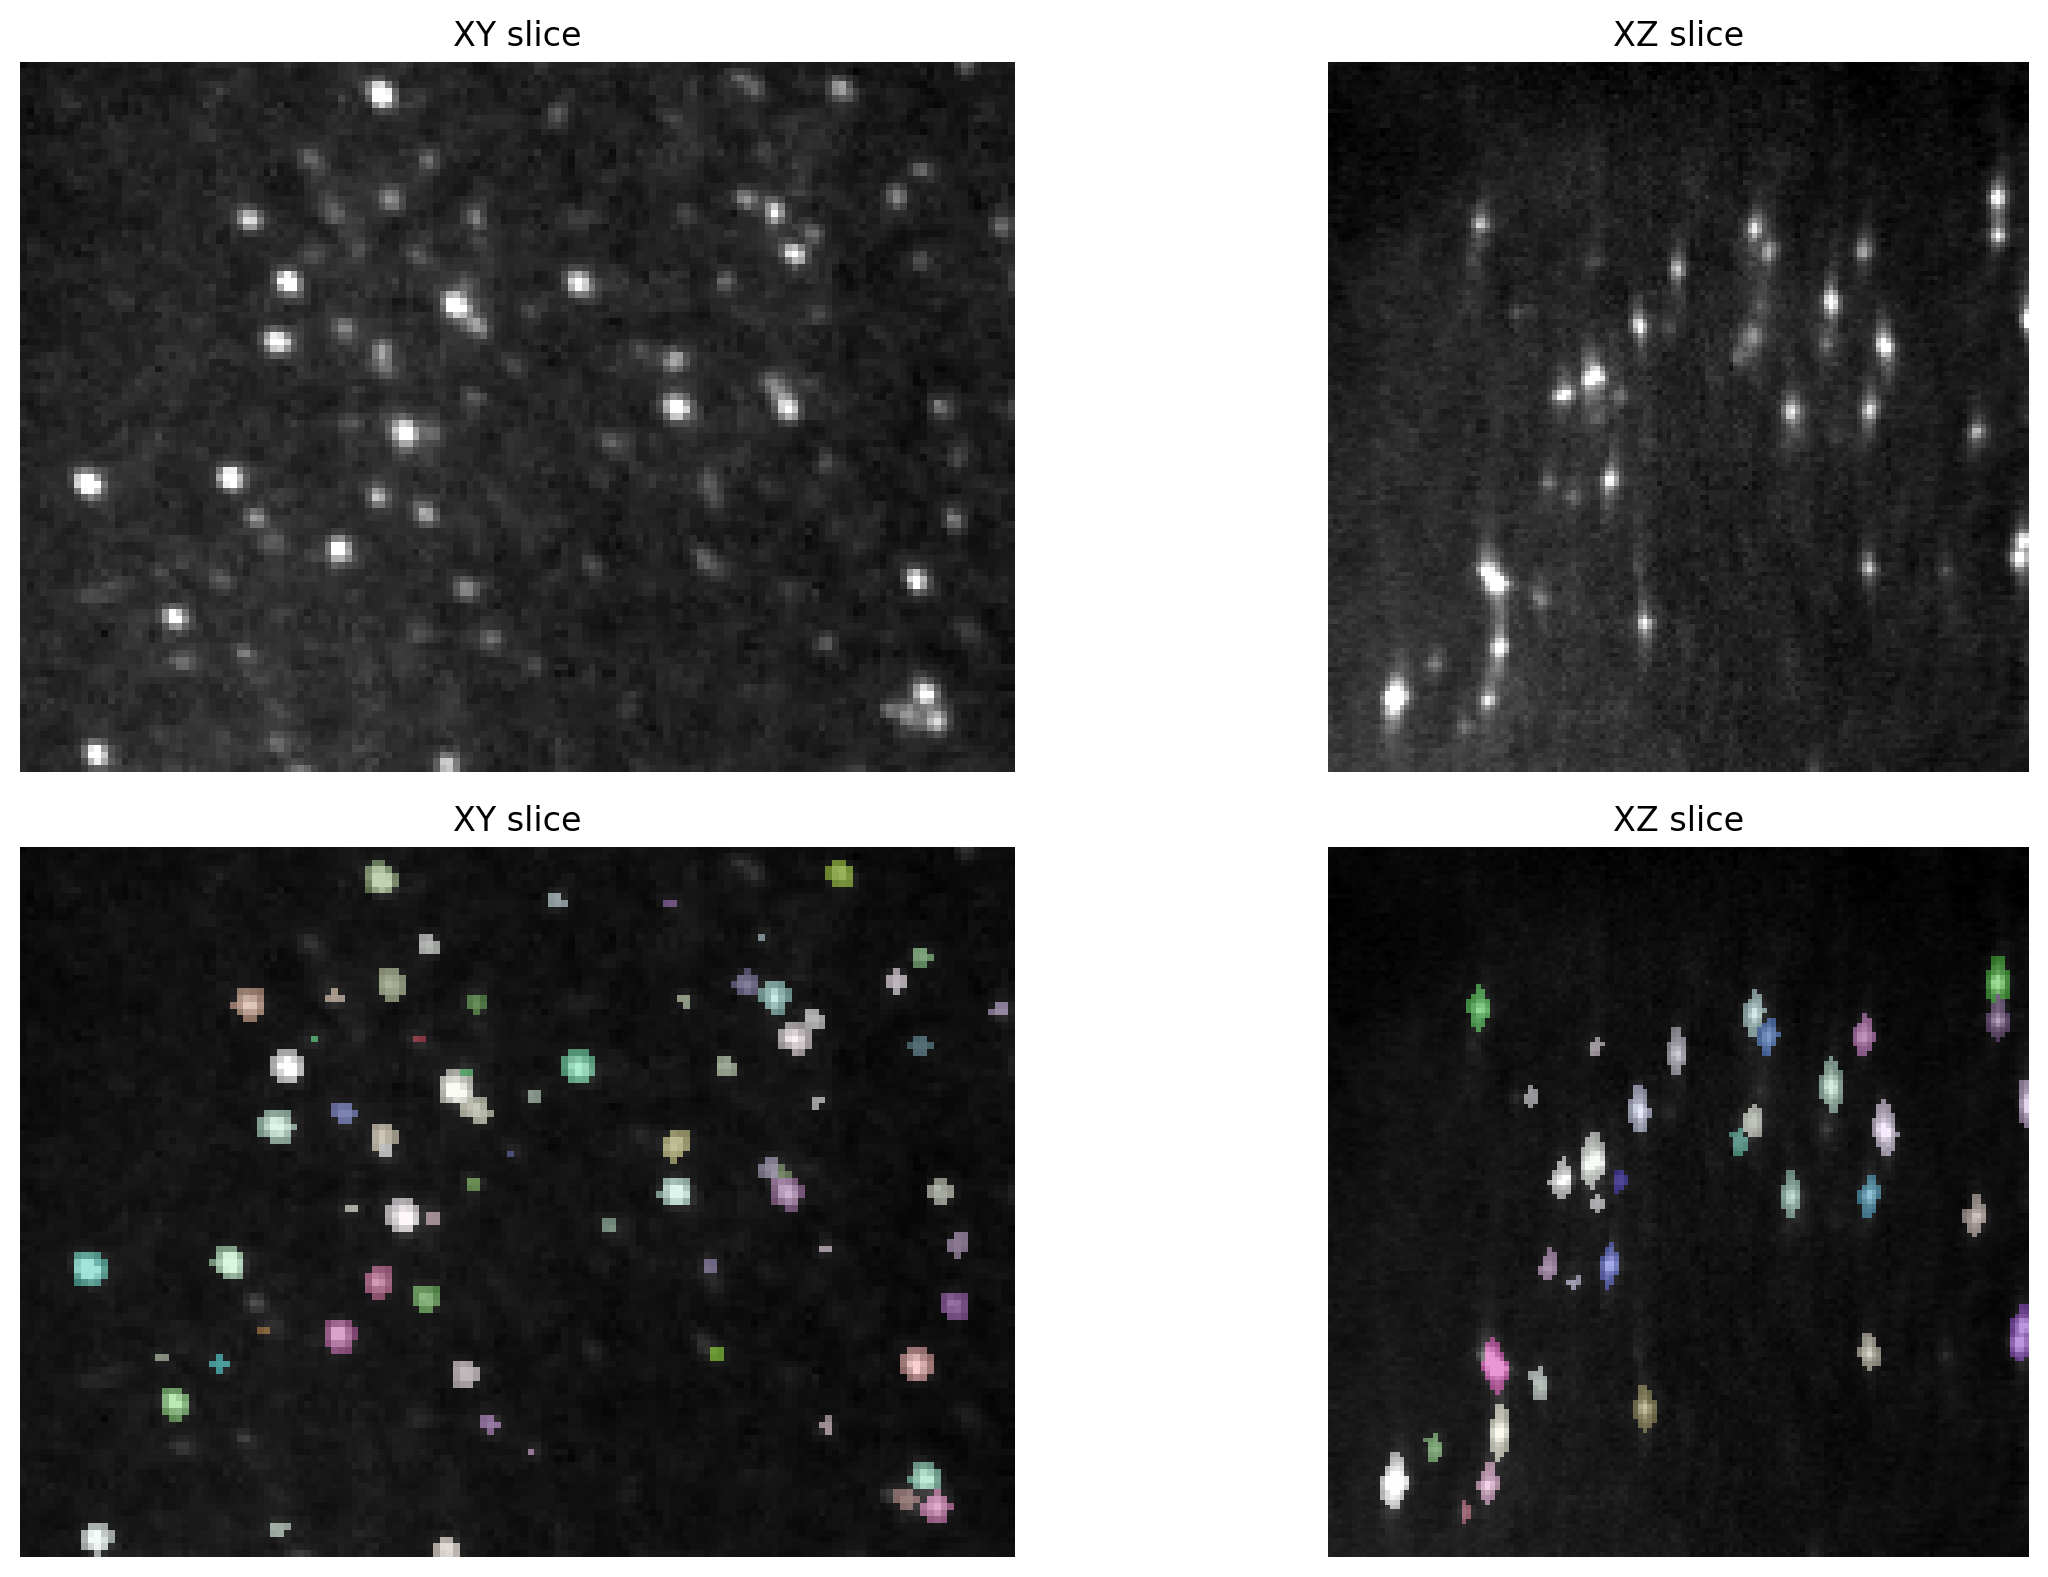

In [9]:
example(model, 0)